In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error


## La Serie


In [2]:
import pandas as pd
import tensorflow as tf
from datetime import datetime

tf.random.set_seed(123)

# Leer el archivo Excel y parsear la fecha
df = pd.read_excel("Datos Originales/Consumo.xlsx")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.set_index("Fecha", inplace=True)

# Filtrar únicamente la columna de Diesel alto azufre
serie = df[["Diesel alto azufre"]].dropna()

print('\n Datos parseados:')
serie.head()


 Datos parseados:


,Diesel alto azufre
Fecha,
2000-01-01,634667.06
2000-02-01,642380.66
2000-03-01,699807.25
2000-04-01,586803.98
2000-05-01,656948.20


A continuación podemos ver el gráfico de la serie. 

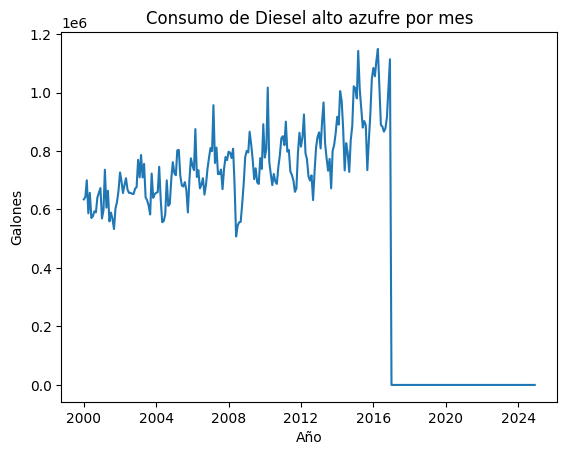

In [3]:
plt.plot(serie)
plt.gca().set(title="Consumo de Diesel alto azufre por mes", xlabel="Año", ylabel="Galones")
plt.show()

(Como se puede ver la serie no es estacionaria en media y la LSTM funciona mejor con series estacionarizadas así que vamos a diferenciarla na vez a ver si es suficiente para estacionarizarla en media)

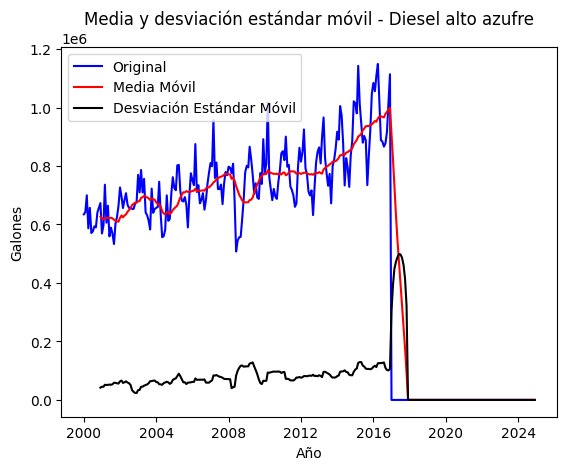

In [4]:
# Calcular media móvil y desviación estándar móvil de los últimos 12 meses
mediaMovil = serie.rolling(window=12).mean()
deMovil = serie.rolling(window=12).std()

# Graficar resultados
plt.plot(serie, color="blue", label="Original")
plt.plot(mediaMovil, color='red', label='Media Móvil')
plt.plot(deMovil, color='black', label='Desviación Estándar Móvil')
plt.legend(loc='best')
plt.title('Media y desviación estándar móvil - Diesel alto azufre')
plt.xlabel('Año')
plt.ylabel('Galones')
plt.show()

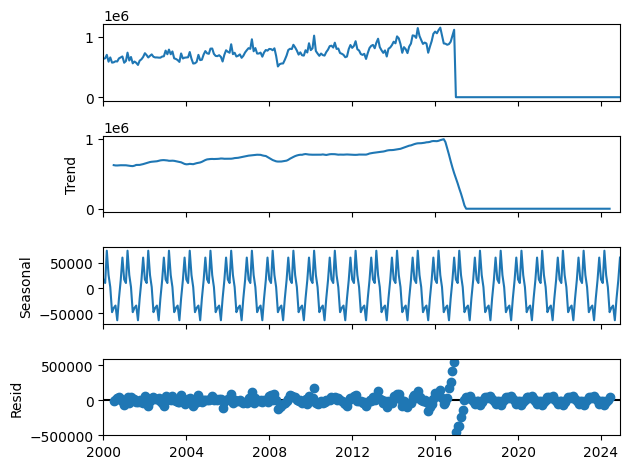

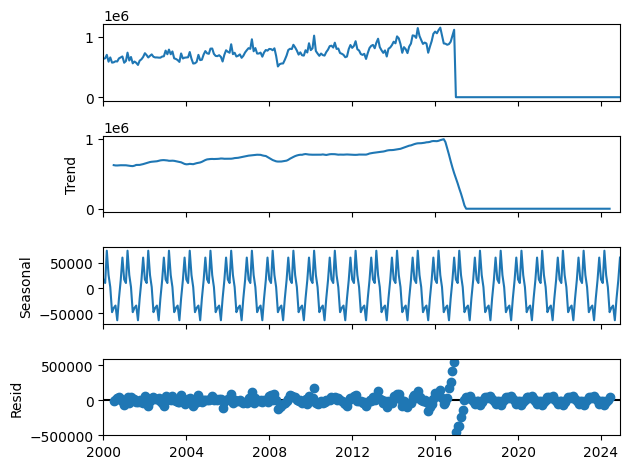

In [5]:
descomposicion = seasonal_decompose(serie)
descomposicion.plot()

En este gráfico se puede observar que hay tendencia por lo que la serie no parece ser estacionaria en media y tampoco en varianza.

In [6]:
from statsmodels.tsa.stattools import adfuller

print('Resultados del Test de Dickey-Fuller para Diesel alto azufre')
dfTest = adfuller(serie["Diesel alto azufre"], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=[
    'Estadístico de prueba',
    'p-value',
    '# de retardos usados',
    '# de observaciones usadas'
])
for key, value in dfTest[4].items():
    salidaDf[f'Valor crítico ({key})'] = value

print(salidaDf)

Resultados del Test de Dickey-Fuller para Diesel alto azufre
Estadístico de prueba         -0.901169
p-value                        0.787587
# de retardos usados           6.000000
# de observaciones usadas    293.000000
Valor crítico (1%)            -3.452867
Valor crítico (5%)            -2.871455
Valor crítico (10%)           -2.572053
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias, es decir, tiene una tendencia o depende mucho de su valor pasado (no es estacionaria). 

Como la serie no es estacionaria en media, vamos a probar con una diferenciación

In [7]:
print('Resultados del Test de Dickey-Fuller para una diferenciación de la serie Diesel alto azufre')

# Diferenciar la serie
serie_diff = serie["Diesel alto azufre"].diff()
serie_diff.fillna(0, inplace=True)

# Prueba de Dickey-Fuller sobre la serie diferenciada
dfTest = adfuller(serie_diff)
salidaDf = pd.Series(dfTest[0:4], index=[
    'Estadístico de prueba',
    'p-value',
    '# de retardos usados',
    '# de observaciones usadas'
])
for key, value in dfTest[4].items():
    salidaDf['Valor crítico (%s)' % key] = value

print(salidaDf)

Resultados del Test de Dickey-Fuller para una diferenciación de la serie Diesel alto azufre
Estadístico de prueba       -9.451944e+00
p-value                      4.591291e-16
# de retardos usados         5.000000e+00
# de observaciones usadas    2.940000e+02
Valor crítico (1%)          -3.452790e+00
Valor crítico (5%)          -2.871422e+00
Valor crítico (10%)         -2.572035e+00
dtype: float64


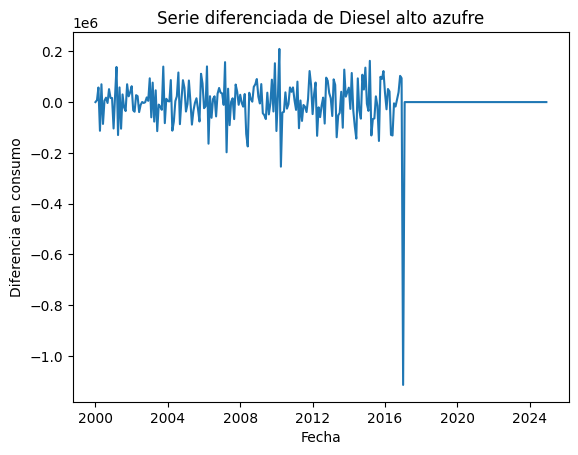

In [8]:
plt.plot(serie_diff)
plt.title("Serie diferenciada de Diesel alto azufre")
plt.xlabel("Fecha")
plt.ylabel("Diferencia en consumo")
plt.show()

Como ya han podido explorarlo, las redes neuronales (como LSTM) son sensibles a la escala de los datos. Si hay valores grandes, junto con pequeños, la red puede tener dificultades al aprender, especialmente usando funciones de activación como tanh o sigmoid. (Además que esto facilita el entrenamiento). 

Como las redes neuronales trabajan mejor con los datos normalizados, vamos a normalizar la serie. 

Al normalizarla, estamos haciendo que la data tenga una media de 0 y una desviación estándar de 1. 

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
serie_diff_scaled = scaler.fit_transform(serie_diff.values.reshape(-1, 1))
serie_diff_scaled[:6]

array([[ 0.02384607],
       [ 0.11079201],
       [ 0.67114547],
       [-1.24990096],
       [ 0.81449569],
       [-0.94584549]])

Vamos a separar la serie en entrenamiento, validación y prueba. En este caso, tendremos 60% para entrenamiento y 20% para validación y prueba respectivamente.

In [10]:
# Largo total de la serie
total_len = len(serie_diff_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
train = serie_diff_scaled[:train_end]
validation = serie_diff_scaled[train_end:val_end]
test = serie_diff_scaled[val_end:]

# Redimensionar para modelos tipo LSTM
train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(train)} | Validation: {len(validation)} | Test: {len(test)}")

Total registros: 300
Train: 180 | Validation: 60 | Test: 60


In [11]:
train, type(train)

(array([[ 0.02384607],
        [ 0.11079201],
        [ 0.67114547],
        [-1.24990096],
        [ 0.81449569],
        [-0.94584549],
        [ 0.08602274],
        [ 0.21923941],
        [-0.01701827],
        [ 0.59834527],
        [ 0.2038894 ],
        [ 0.20640323],
        [-1.14789372],
        [ 0.3442016 ],
        [ 1.58313945],
        [-1.43954902],
        [ 0.67563624],
        [-1.15686775],
        [ 0.36334846],
        [-0.21180564],
        [-0.37560274],
        [ 0.81583219],
        [ 0.28067339],
        [ 0.45255663],
        [ 0.72813357],
        [-0.34054573],
        [-0.40409225],
        [ 0.33119211],
        [ 0.28895025],
        [-0.41963907],
        [-0.10080969],
        [ 0.02765751],
        [-0.01487404],
        [ 0.0169553 ],
        [ 0.23066121],
        [ 0.07785048],
        [ 1.07945706],
        [-0.65313337],
        [ 0.8884012 ],
        [-0.84248089],
        [ 0.54635651],
        [-1.26611766],
        [-0.08702262],
        [-0

In [12]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)


In [13]:
x_train

array([[ 0.02384607],
       [ 0.11079201],
       [ 0.67114547],
       [-1.24990096],
       [ 0.81449569],
       [-0.94584549],
       [ 0.08602274],
       [ 0.21923941],
       [-0.01701827],
       [ 0.59834527],
       [ 0.2038894 ],
       [ 0.20640323],
       [-1.14789372],
       [ 0.3442016 ],
       [ 1.58313945],
       [-1.43954902],
       [ 0.67563624],
       [-1.15686775],
       [ 0.36334846],
       [-0.21180564],
       [-0.37560274],
       [ 0.81583219],
       [ 0.28067339],
       [ 0.45255663],
       [ 0.72813357],
       [-0.34054573],
       [-0.40409225],
       [ 0.33119211],
       [ 0.28895025],
       [-0.41963907],
       [-0.10080969],
       [ 0.02765751],
       [-0.01487404],
       [ 0.0169553 ],
       [ 0.23066121],
       [ 0.07785048],
       [ 1.07945706],
       [-0.65313337],
       [ 0.8884012 ],
       [-0.84248089],
       [ 0.54635651],
       [-1.26611766],
       [-0.08702262],
       [-0.18215198],
       [-0.31925628],
       [ 1

In [14]:
y_train, type(y_train)

(array([ 0.11079201,  0.67114547, -1.24990096,  0.81449569, -0.94584549,
         0.08602274,  0.21923941, -0.01701827,  0.59834527,  0.2038894 ,
         0.20640323, -1.14789372,  0.3442016 ,  1.58313945, -1.43954902,
         0.67563624, -1.15686775,  0.36334846, -0.21180564, -0.37560274,
         0.81583219,  0.28067339,  0.45255663,  0.72813357, -0.34054573,
        -0.40409225,  0.33119211,  0.28895025, -0.41963907, -0.10080969,
         0.02765751, -0.01487404,  0.0169553 ,  0.23066121,  0.07785048,
         1.07945706, -0.65313337,  0.8884012 , -0.84248089,  0.54635651,
        -1.26611766, -0.08702262, -0.18215198, -0.31925628,  1.59934813,
        -0.91098066,  0.17087574,  0.07022885,  0.05262324,  1.0010682 ,
        -1.24389886, -0.84854801,  0.0692012 ,  0.27977239,  1.33714558,
        -0.95647376,  0.09649512,  0.99562348,  0.66144668, -0.39514754,
        -0.06154425,  0.98220376,  0.0447817 , -0.97524419, -0.35507797,
        -0.01142206,  0.19367402, -0.28525701, -0.8


## Creando el modelo
Para que pueda hacerse el modelo se le tiene que suministrar una matriz de 3 dimensiones siendo estas:
- ***Muestras:*** número de observaciones en cada lote (batch), también conocido como tamaño del lote (batch size).
- ***Pasos de tiempo:*** Pasos de tiempo separados para una observación dada. En este ejemplo los pasos de tiempo = 1
- ***Características:*** Para un caso univariante, como en este ejemplo, las características = 1  

Vamos a convertir los conjuntos en matrices de 3 dimensiones
(n_samples, time_steps, n_features)

In [15]:
(x_train.shape[0],1,1)

(179, 1, 1)

In [16]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

59

### Creamos el modelo.   
Vamos a utilizar solo una capa lstm  

LSTM(units, input_shape=(pasos, características), stateful=False)
- units: cantidad de neuronas. Cada una es como una "mini-memoria" que puede aprender patrones en secuencias.
- input_shape: pasos (lags) y features (cant de variables)
- batch_input_shape: Solo se usa si stateful=True. Igual que input_shape, pero le agregas el tamaño fijo del batch (batch_size). O sea: (batch_size, pasos, características).
- stateful: mantiene el estado (memoria) entre batches, ayuda para entender dependencias a largo plazo entre batches

Dense(1)
#
- Toma lo que sale de la LSTM y le aplica una transformación lineal con pesos y bias.
- En este caso, Dense(1) significa: produce una sola salida (por ejemplo, una predicción de un número, como el siguiente valor de la serie).

In [17]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

# modelo1.add(LSTM(
#     units=unidades, 
#     batch_input_shape=(lote, paso, caracteristicas), 
#     stateful=True  # activamos estado entre batches
# ))
modelo1.add(Dense(1))
modelo1.summary()

C:\Users\jemil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

Compilamos el modelo. Las métricas que nos van a servir para saber como funciona el modelo en términos de la pérdida es el error medio cuadrado. 

In [18]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

Vamos a entrenar el modelo. Para eso configuramos las epochs(épocas) que es la cantidad de iteraciones. Lo pondremos en 50.

In [19]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5531 - val_loss: 3.0155
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5319 - val_loss: 3.0065
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5169 - val_loss: 2.9990
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5054 - val_loss: 2.9926
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4966 - val_loss: 2.9874
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4897 - val_loss: 2.9832
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4841 - val_loss: 2.9797
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4796 - val_loss: 2.9770
Epoch 9/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4759 - val_loss: 2.9748
Epoch 10/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4727 - val_loss: 2.9730
Epoch 11/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4700 - val_loss: 2.9716
Epoch 12/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

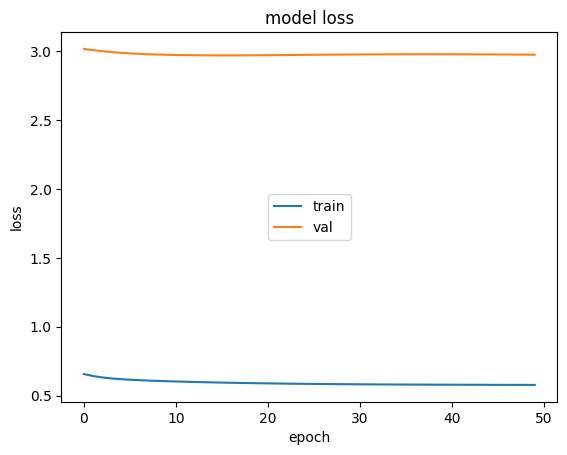

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

Evaluemos ahora el modelo según la pérdida en cada uno de los conjuntos de datos.

In [21]:
print("Pérdida en Train")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4819  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.7996
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0364


0.036375924944877625

Ahora vamos a predecir con el modelo 1.  

In [22]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val1 = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = serie.values , n=train_end)
prediccion_test1 = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = serie.values , n = len(serie.values) - len(x_test))


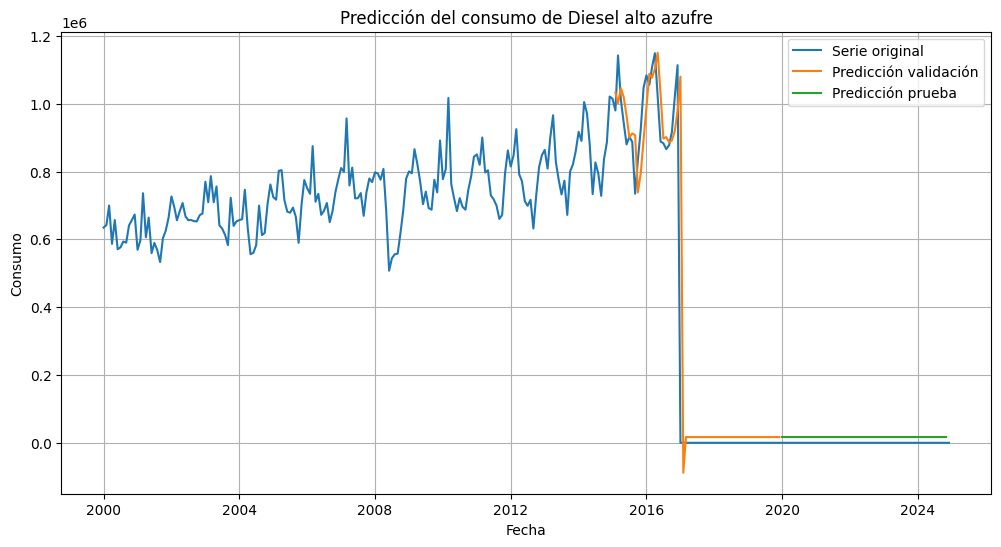

In [23]:
# df_val = pd.DataFrame(prediccion_val,index=serie[(train_prop):train_prop+val_prop].index) 
# df_test = pd.DataFrame(prediccion_test,index=serie[train_prop+len(df_val):len(serie)].index)
df_val = pd.DataFrame(prediccion_val1, index=serie[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test1, index=serie[val_end:].index[:len(prediccion_test1)])


plt.figure(figsize=(12,6))
plt.plot(serie, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')
plt.legend()
plt.title('Predicción del consumo de Diesel alto azufre')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.grid(True)
plt.show()



### Modelo 2

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

unidades = 50
paso = 12
caracteristicas = 1

modelo2 = Sequential()
modelo2.add(LSTM(
    units=unidades, 
    return_sequences=True,  # Necesario para apilar otra capa LSTM
    input_shape=(paso, caracteristicas),
    stateful=False
))
modelo2.add(Dropout(0.2))  # Regularización

modelo2.add(LSTM(
    units=25,
    stateful=False
))
modelo2.add(Dense(1))  # Capa de salida
modelo2.summary()


C:\Users\jemil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 12, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,026 (70.41 KB)

 Trainable params: 18,026 (70.41 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
modelo2.compile(loss='mean_squared_error',optimizer="rmsprop")

In [26]:
epocas = 50
history= modelo2.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5634 - val_loss: 3.0329
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5423 - val_loss: 3.0249
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5188 - val_loss: 3.0111
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5048 - val_loss: 3.0021
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4890 - val_loss: 2.9927
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4838 - val_loss: 2.9894
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4808 - val_loss: 2.9844
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4818 - val_loss: 2.9836
Epoch 9/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4689 - val_loss: 2.9794
Epoch 10/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4658 - val_loss: 2.9770
Epoch 11/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4601 - val_loss: 2.9797
Epoch 12/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

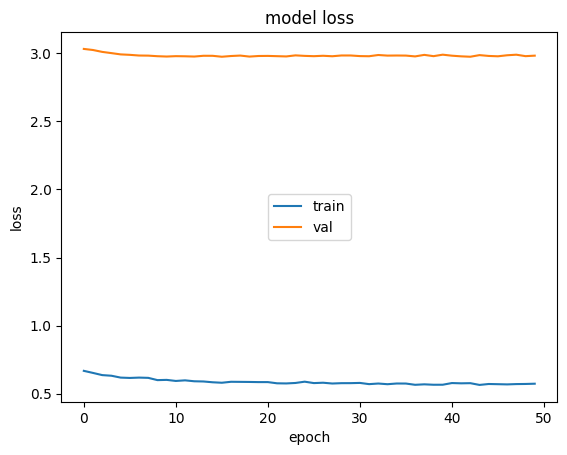

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [28]:
print("Pérdida en Train")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4865  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.8159
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0237


0.02367428131401539

In [29]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo2.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val2 = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = serie.values , n=train_end)
prediccion_test2 = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = serie.values , n = len(serie.values) - len(x_test))

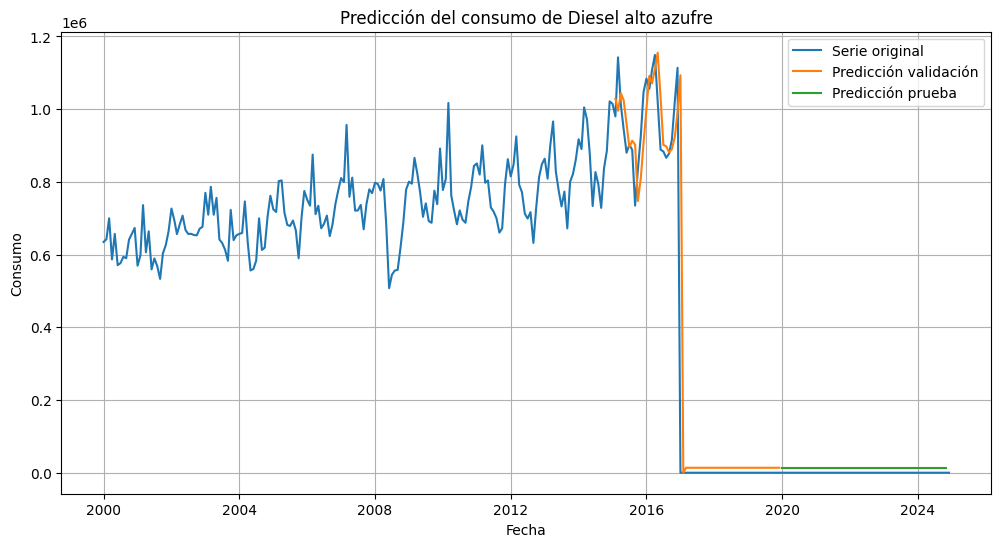

In [30]:
# df_val = pd.DataFrame(prediccion_val,index=serie[(train_prop):train_prop+val_prop].index) 
# df_test = pd.DataFrame(prediccion_test,index=serie[train_prop+len(df_val):len(serie)].index)
df_val = pd.DataFrame(prediccion_val2, index=serie[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test2, index=serie[val_end:].index[:len(prediccion_test2)])


plt.figure(figsize=(12,6))
plt.plot(serie, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')
plt.legend()
plt.title('Predicción del consumo de Diesel alto azufre')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.grid(True)
plt.show()

In [31]:
# --- Modelo 1 ---
rmse_val_1 = np.sqrt(mean_squared_error(y_val, prediccion_val1))
rmse_test_1 = np.sqrt(mean_squared_error(y_test, prediccion_test1))

# --- Modelo 2 ---
rmse_val_2 = np.sqrt(mean_squared_error(y_val, prediccion_val2))
rmse_test_2 = np.sqrt(mean_squared_error(y_test, prediccion_test2))

# Mostrar resultados
print(f"Modelo 1 - RMSE validación: {rmse_val_1:.2f} | RMSE prueba: {rmse_test_1:.2f}")
print(f"Modelo 2 - RMSE validación: {rmse_val_2:.2f} | RMSE prueba: {rmse_test_2:.2f}")


Modelo 1 - RMSE validación: 620063.16 | RMSE prueba: 16920.54
Modelo 2 - RMSE validación: 621585.12 | RMSE prueba: 13650.40


Nos importa mas el RMSE de prueba